In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
image_size = 350
batch_size = 16
save_model_filename = 'resnet_(1).h5'

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

In [4]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [5]:
train['label'] = train['label'].astype('str')

In [6]:
image_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                                horizontal_flip=True, vertical_flip=True, fill_mode='nearest', brightness_range=[0.7, 1.3],
                                rotation_range=270, zoom_range=0.2, shear_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                validation_split=0.2, rescale = 1./255)

test_gen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = image_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                subset='training', batch_size=batch_size, seed=1,
                                                shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

validation_generator = image_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', batch_size=batch_size, seed=1,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [8]:
def build_resnet50():
    model = Sequential()
    model.add(ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [9]:
model = build_resnet50()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 11, 11, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=['accuracy']
)

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(save_model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=1, min_lr=0, verbose=1)

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


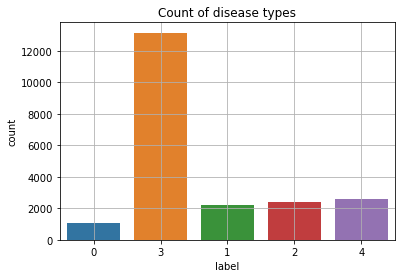

In [12]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of disease types')
plt.grid()
plt.show()

In [13]:
epoch = 30

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/30
1070/1070 [==============================] - ETA: 0s - loss: 1.3015 - accuracy: 0.5633
Epoch 00001: val_loss improved from inf to 1.14754, saving model to resnet_(1).h5
1070/1070 [==============================] - 620s 580ms/step - loss: 1.3015 - accuracy: 0.5633 - val_loss: 1.1475 - val_accuracy: 0.6202
Epoch 2/30
1070/1070 [==============================] - ETA: 0s - loss: 1.0722 - accuracy: 0.6154
Epoch 00002: val_loss improved from 1.14754 to 1.07329, saving model to resnet_(1).h5
1070/1070 [==============================] - 539s 503ms/step - loss: 1.0722 - accuracy: 0.6154 - val_loss: 1.0733 - val_accuracy: 0.6291
Epoch 3/30
1070/1070 [==============================] - ETA: 0s - loss: 0.9810 - accuracy: 0.6362
Epoch 00003: val_loss did not improve from 1.07329

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1070/1070 [==============================] - 530s 496ms/step - loss: 0.9810 - accuracy: 0.6362 - val_loss: 1.5702 - val_accuracy: 0

train loss: 0.5984734892845154
train accuracy: 0.792323887348175
dev loss: 0.5391316413879395
dev accuracy: 0.8088338375091553


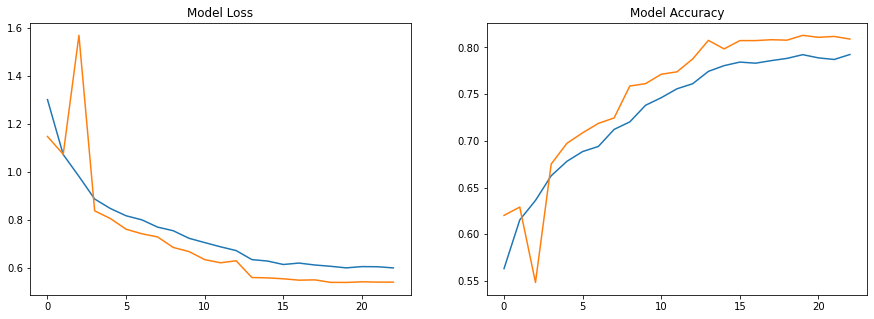

In [14]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['accuracy', 'val_accuracy']])
axs[1].set_title('Model Accuracy')

plt.show()

In [15]:
pred = model.predict(validation_generator)
predictions = np.argmax(pred, axis=1)
actual = validation_generator.classes

from sklearn.metrics import classification_report

report = classification_report(actual, predictions, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

              precision    recall  f1-score   support

         CBB       0.47      0.39      0.43       200
        CBSD       0.72      0.61      0.66       436
         CGM       0.77      0.54      0.63       495
         CMD       0.91      0.95      0.93      2638
     Healthy       0.55      0.70      0.62       510

    accuracy                           0.81      4279
   macro avg       0.68      0.64      0.65      4279
weighted avg       0.81      0.81      0.81      4279



In [16]:
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

In [17]:
test_path = '../input/cassava-leaf-disease-classification/test_images'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

In [18]:
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.resnet50.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

Found 1 validated image filenames belonging to 1 classes.


In [19]:
output = model.predict(test_generator)

In [20]:
submission = pd.DataFrame()
submission['image_id'] = list(os.listdir(test_path))
submission['label'] = np.argmax(output, axis=1)
submission.to_csv("submission.csv", index=False)

In [21]:
submission.head()

,image_id,label
0,2216849948.jpg,2


In [22]:
model.save('model_final.h5')

In [23]:
model.save_weights('model_weights')